In [3]:
# !python -m venv env
# !source env/bin/activate
!pip install -r ../requirements.txt -q

  Using cached numpy-1.24.2-cp311-cp311-win_amd64.whl (14.8 MB)
  Using cached tqdm-4.65.0-py3-none-any.whl (77 kB)
  Using cached matplotlib-3.7.1-cp311-cp311-win_amd64.whl (7.6 MB)
  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)
  Using cached scikit_learn-1.2.2-cp311-cp311-win_amd64.whl (8.3 MB)
  Using cached pandas-1.5.3-cp311-cp311-win_amd64.whl (10.3 MB)
  Using cached contourpy-1.0.7-cp311-cp311-win_amd64.whl (162 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached fonttools-4.39.2-py3-none-any.whl (1.0 MB)
  Using cached kiwisolver-1.4.4-cp311-cp311-win_amd64.whl (55 kB)
  Using cached Pillow-9.4.0-cp311-cp311-win_amd64.whl (2.5 MB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
  Using cached scipy-1.10.1-cp311-cp311-win_amd64.whl (42.2 MB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  Using cached pytz-2022.7.1-py2.py3-none-any.whl (499 kB)



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.svm import LinearSVR
from sklearn.model_selection import train_test_split

## Загрузка данных

In [36]:
data = pd.read_csv('..\data\data.csv', sep=';',
                   index_col='Unnamed: 0', encoding='cp1251')


In [14]:
data

,PORO,SW,KRW,system_number,@NTG@,@RVAR@,@PERMX@,l_horiz,param_x,param_y,n_frac,xf_prod,xf_inj,rotation_angle,switch_period,dFrac,КИН (100)
1,0.17,0.3,0.15,1,0.1,50,0.05,0,100,100,1,50,50,45,1,0,0.0441
2,0.17,0.3,0.15,1,0.1,50,0.05,0,100,100,1,50,50,45,3,0,0.0514
3,0.17,0.3,0.15,1,0.1,50,0.05,0,100,100,1,50,50,45,6,0,0.0559
4,0.17,0.3,0.15,1,0.1,50,0.05,0,100,100,1,50,50,0,1,0,0.1548
5,0.17,0.3,0.15,1,0.1,50,0.05,0,100,100,1,50,50,0,3,0,0.1576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124412,0.17,0.3,0.15,1301,0.6,1000,2.00,2000,300,2200,20,100,100,45,10000,100,0.0754
124413,0.17,0.3,0.15,1301,0.6,1000,2.00,1000,300,1200,10,150,150,45,10000,100,0.0769
124414,0.17,0.3,0.15,1301,0.6,1000,2.00,1200,300,1400,12,150,150,45,10000,100,0.0766
124415,0.17,0.3,0.15,1301,0.6,1000,2.00,1500,300,1700,15,150,150,45,10000,100,0.0764


### Перемешиваем данные и удаляем параметры с нулевой дисперсией

In [5]:
data_sample = data.sample(frac=1).reset_index(
    drop=True).drop(['param_y', 'PORO', 'SW', 'KRW'], axis=1)
data_sample

,system_number,@NTG@,@RVAR@,@PERMX@,l_horiz,param_x,n_frac,xf_prod,xf_inj,rotation_angle,switch_period,dFrac,КИН (100)
0,13,0.60,250,0.30,2000,300,20,50,50,90,3,100,0.4026
1,14,0.30,250,1.00,1000,100,10,50,50,0,6,100,0.3444
2,13,0.45,500,0.30,1000,300,20,150,150,45,3,50,0.3815
3,14,0.45,1000,2.00,2000,300,40,150,150,45,6,50,0.4186
4,14,0.60,500,2.00,1000,200,10,100,150,45,1,100,0.4444
...,...,...,...,...,...,...,...,...,...,...,...,...,...
124411,1301,0.30,250,2.00,1000,300,10,150,150,90,10000,100,0.0762
124412,13,0.30,250,1.00,1500,200,30,100,150,45,1,50,0.3266
124413,1301,0.60,250,2.00,2000,200,40,50,50,45,10000,50,0.0728
124414,1401,0.30,500,0.05,1500,300,15,100,100,90,10000,100,0.0663


### Применяем one-hot кодирование для категориальных признаков, нормализуем числовые

In [135]:
enc = OneHotEncoder()
X = data_sample[['system_number', 'rotation_angle']]
enc.fit(X)
data_cat = enc.transform(
    data_sample[['system_number', 'rotation_angle']]).toarray()

In [161]:
x = data_sample.drop(['system_number', 'rotation_angle', 'КИН (100)'], axis = 1).to_numpy()
min_max_scaler = MinMaxScaler()
mms = MinMaxScaler()
mms.fit(x)
data_norm = min_max_scaler.fit_transform(x)

In [8]:
data_norm.shape

(124416, 10)

In [9]:
data_cat.shape

(124416, 13)

In [10]:
target = np.reshape(data_sample['КИН (100)'].to_numpy(), (-1, 1))

In [11]:
data_nn = np.concatenate((data_cat, data_norm), axis=1)

In [12]:
data_nn.shape

(124416, 23)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data_nn, target, test_size=0.2, random_state=42)

In [52]:
pd.DataFrame(data_nn)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.210526,0.128205,1.00,1.0,0.487179,0.0,0.0,0.0002,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.4,0.210526,0.487179,0.50,0.0,0.230769,0.0,0.0,0.0005,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.7,0.473684,0.128205,0.50,1.0,0.487179,1.0,0.4,0.0002,0.5
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.7,1.000000,1.000000,1.00,1.0,1.000000,1.0,0.4,0.0005,0.5
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.473684,1.000000,0.50,0.5,0.230769,0.5,0.4,0.0000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124411,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.4,0.210526,1.000000,0.50,1.0,0.230769,1.0,0.4,1.0000,1.0
124412,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.4,0.210526,0.487179,0.75,0.5,0.743590,0.5,0.4,0.0000,0.5
124413,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.210526,1.000000,1.00,0.5,1.000000,0.0,0.0,1.0000,0.5
124414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.4,0.473684,0.000000,0.75,1.0,0.358974,0.5,0.2,1.0000,1.0


In [53]:
pd.DataFrame(data_norm)

,0,1,2,3,4,5,6,7,8,9
0,1.0,0.210526,0.128205,1.00,1.0,0.487179,0.0,0.0,0.0002,1.0
1,0.4,0.210526,0.487179,0.50,0.0,0.230769,0.0,0.0,0.0005,1.0
2,0.7,0.473684,0.128205,0.50,1.0,0.487179,1.0,0.4,0.0002,0.5
3,0.7,1.000000,1.000000,1.00,1.0,1.000000,1.0,0.4,0.0005,0.5
4,1.0,0.473684,1.000000,0.50,0.5,0.230769,0.5,0.4,0.0000,1.0
...,...,...,...,...,...,...,...,...,...,...
124411,0.4,0.210526,1.000000,0.50,1.0,0.230769,1.0,0.4,1.0000,1.0
124412,0.4,0.210526,0.487179,0.75,0.5,0.743590,0.5,0.4,0.0000,0.5
124413,1.0,0.210526,1.000000,1.00,0.5,1.000000,0.0,0.0,1.0000,0.5
124414,0.4,0.473684,0.000000,0.75,1.0,0.358974,0.5,0.2,1.0000,1.0


## Обучение моделей

### Метод опорных векторов

In [15]:
from sklearn.svm import SVR
regressor = SVR()
regressor.fit(X_train, y_train.ravel())

SVR()

In [16]:
regressor.score(X_test, y_test.ravel())

0.8799717214800279

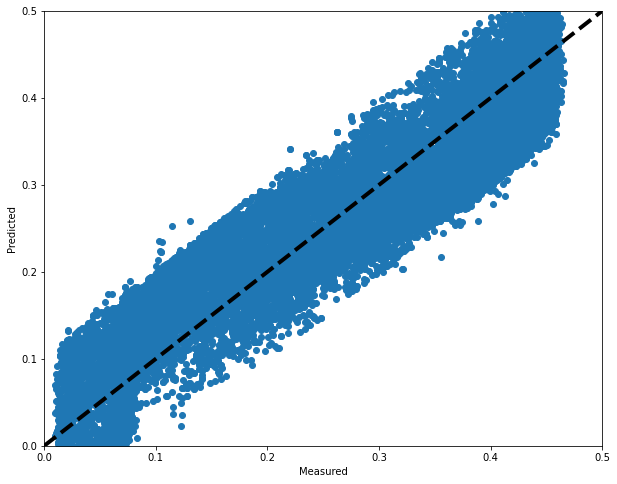

In [23]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (10, 8)

ax.scatter(y_test, regressor.predict(X_test))
ax.plot([0, 0.5], [0, 0.5], 'k--', lw=4)
#ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_ylim(bottom=0, top=0.5)
ax.set_xlim(left=0, right=0.5)
plt.show()

In [84]:
regressor1 = SVR()
regressor1.fit(X_train_lin, y_train_lin.ravel())

SVR()

In [86]:
regressor1.score(X_test_lin, y_test_lin.ravel())

0.881118134122879

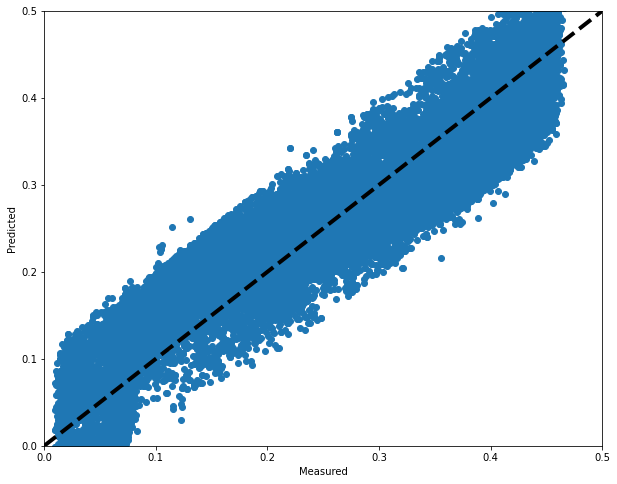

In [88]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (10, 8)

ax.scatter(y_test, regressor1.predict(X_test_lin))
ax.plot([0, 0.5], [0, 0.5], 'k--', lw=4)
#ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_ylim(bottom=0, top=0.5)
ax.set_xlim(left=0, right=0.5)
plt.show()

### Метод ближайших соседей

In [25]:
from sklearn.neighbors import KNeighborsRegressor
knn_model = KNeighborsRegressor(n_neighbors=10)
knn_model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=10)

In [26]:
knn_model.score(X_test, y_test)

0.8867989790034005

In [91]:
knn_model1 = KNeighborsRegressor(n_neighbors=10, weights='distance')
knn_model1.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=10, weights='distance')

In [92]:
knn_model1.score(X_test, y_test)

0.9920191044066629

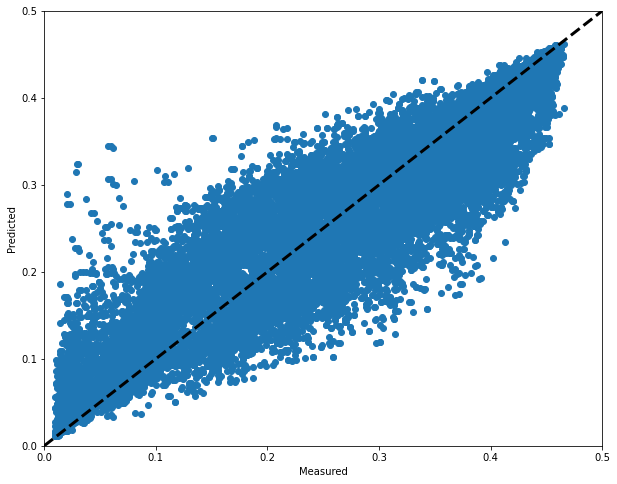

In [29]:
fig, ax = plt.subplots()
ax.scatter(y_test, knn_model.predict(X_test))
ax.plot([0, 0.5], [0, 0.5], 'k--', lw=3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_ylim(bottom=0, top=0.5)
ax.set_xlim(left=0, right=0.5)
plt.show()

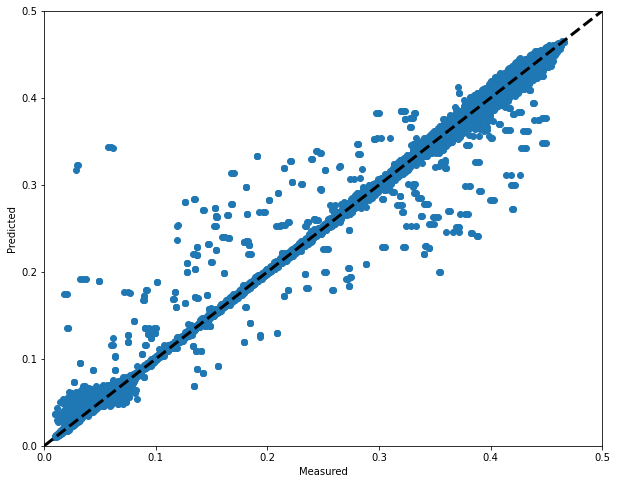

In [93]:
fig, ax = plt.subplots()
ax.scatter(y_test, knn_model1.predict(X_test))
ax.plot([0, 0.5], [0, 0.5], 'k--', lw=3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_ylim(bottom=0, top=0.5)
ax.set_xlim(left=0, right=0.5)
plt.show()

In [94]:
knn_model1 = KNeighborsRegressor(weights='distance')
pipe = Pipeline(steps=[("knn", knn_model1)])


param_grid = {
    "knn__n_neighbors": [5, 10, 15, 20]}
search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.982):
{'knn__n_neighbors': 20}


In [95]:
knn_model2 = KNeighborsRegressor(n_neighbors=20, weights='distance')
knn_model2.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=20, weights='distance')

In [96]:
knn_model2.score(X_test, y_test)

0.9930714408396087

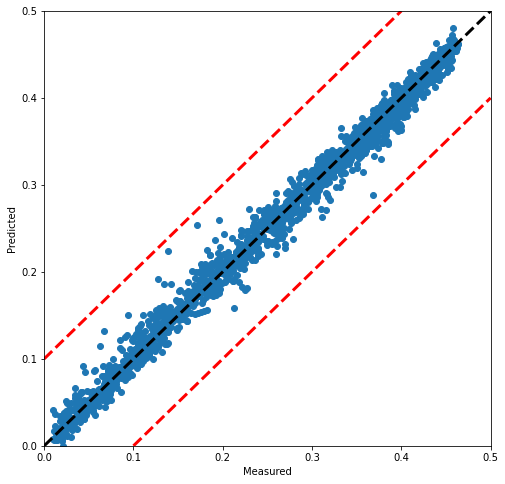

In [275]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (8, 8)

ax.plot(y_test, CAT2.predict(X_test),  "o", markevery=10)
ax.plot([0, 0.5], [0, 0.5], 'k--', lw=3)
ax.plot([0.1, 0.5], [0, 0.4], 'r--', lw=3)
ax.plot([0.0, 0.4], [0.1, 0.5], 'r--', lw=3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_ylim(bottom=0, top=0.5)
ax.set_xlim(left=0, right=0.5)
plt.show()

### Линейная регрессия

In [75]:
enc = OneHotEncoder(drop='first')
X = data_sample[['system_number', 'rotation_angle']]
enc.fit(X)
data_cat = enc.transform(
    data_sample[['system_number', 'rotation_angle']]).toarray()

data_lin = np.concatenate((data_cat, data_norm), axis=1)
data_lin.shape

(124416, 21)

In [76]:
from sklearn.model_selection import train_test_split
X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(
    data_lin, target, test_size=0.2, random_state=42)

In [279]:
from sklearn.linear_model import LinearRegression
linear = LinearRegression().fit(X_train_lin, y_train_lin)
linear.score(X_test_lin, y_test_lin)

0.7154672041087615

In [280]:
linear.coef_

array([[ 0.01704498, -0.08658395,  0.03200925, -0.00553829,  4.92820688,
         4.92707092,  4.97515491,  4.97833676,  4.97556995, -0.01291837,
        -0.0103732 ,  0.11796655,  0.08606449,  0.10618975, -0.07789821,
        -0.0484141 ,  0.01032795,  0.00884291,  0.01624973, -5.18506433,
         0.01587227]])

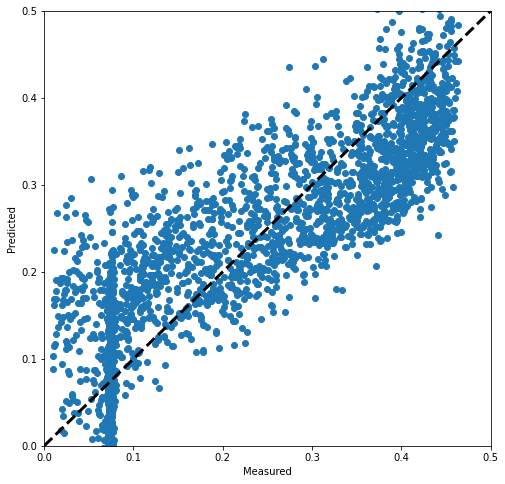

In [281]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (8, 8)

#ax.scatter(y_test, ridge.predict(X_test))
ax.plot(y_test_lin, LIN_pred,  "o", markevery=10)
ax.plot([0, 0.5], [0, 0.5], 'k--', lw=3)
#ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_ylim(bottom=0, top=0.5)
ax.set_xlim(left=0, right=0.5)
plt.show()

In [250]:
SVM_pred = regressor1.predict(X_test_lin)  # 'R2': 0.859   0.881
MLP_pred = model3.predict(X_test)  # 0.944   0.993
CAT_pred = CAT2.predict(X_test)  # 0.981   0.990
RF_pred = rf.predict(X_test)  # 0.982   0.999
KNN_pred = knn_model2.predict(X_test)  # 0.840   0.993
LIN_pred = linear.predict(X_test_lin)  # 0.710   0.715

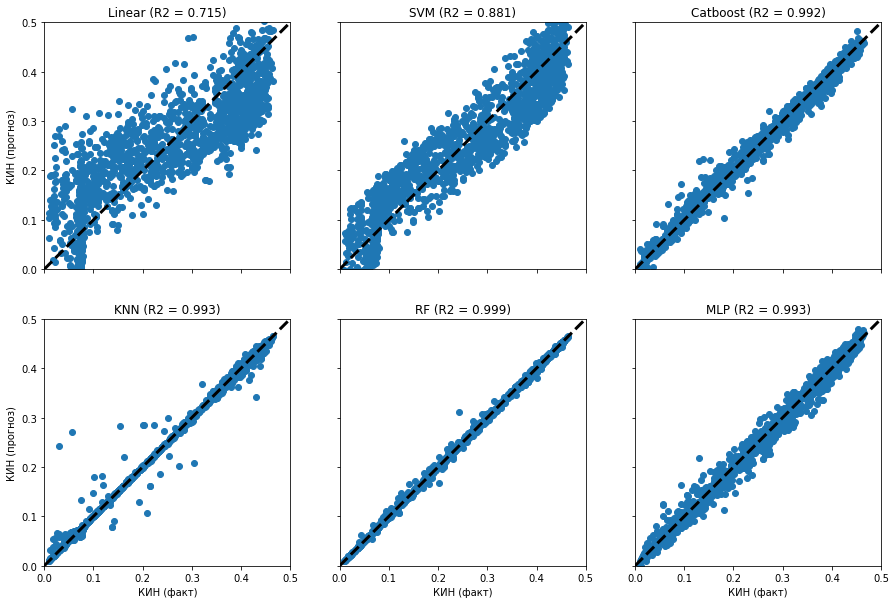

In [256]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10)
mark_ev = 15

fig, axs = plt.subplots(2, 3)
axs[0, 1].plot(y_test_lin, SVM_pred, "o", markevery = mark_ev)
axs[0, 1].plot([0, 0.5], [0, 0.5], 'k--', lw=3)
axs[0, 1].set_title('SVM (R2 = 0.881)')
axs[0, 1].set_ylim(bottom = 0, top = 0.5)
axs[0, 1].set_xlim(left = 0, right = 0.5)
###
axs[1, 2].plot(y_test, MLP_pred, "o", markevery = mark_ev)
axs[1, 2].plot([0, 0.5], [0, 0.5], 'k--', lw=3)
axs[1, 2].set_title('MLP (R2 = 0.993)')
axs[1, 2].set_ylim(bottom = 0, top = 0.5)
axs[1, 2].set_xlim(left = 0, right = 0.5)
###
axs[0, 2].plot(y_test, CAT_pred, "o", markevery = mark_ev)
axs[0, 2].plot([0, 0.5], [0, 0.5], 'k--', lw=3)
axs[0, 2].set_title('Catboost (R2 = 0.992)')
axs[0, 2].set_ylim(bottom = 0, top = 0.5)
axs[0, 2].set_xlim(left = 0, right = 0.5)
###
axs[1, 1].plot(y_test, RF_pred, "o", markevery = mark_ev)
axs[1, 1].plot([0, 0.5], [0, 0.5], 'k--', lw=3)
axs[1, 1].set_title('RF (R2 = 0.999)')
axs[1, 1].set_ylim(bottom = 0, top = 0.5)
axs[1, 1].set_xlim(left = 0, right = 0.5)
###
axs[1, 0].plot(y_test, KNN_pred, "o", markevery = mark_ev)
axs[1, 0].plot([0, 0.5], [0, 0.5], 'k--', lw=3)
axs[1, 0].set_title('KNN (R2 = 0.993)')
axs[1, 0].set_ylim(bottom = 0, top = 0.5)
axs[1, 0].set_xlim(left = 0, right = 0.5)
###
axs[0, 0].plot(y_test_lin, LIN_pred,  "o", markevery = mark_ev)
axs[0, 0].plot([0, 0.5], [0, 0.5], 'k--', lw=3)
axs[0, 0].set_title('Linear (R2 = 0.715)')
axs[0, 0].set_ylim(bottom = 0, top = 0.5)
axs[0, 0].set_xlim(left = 0, right = 0.5)
###

for ax in axs.flat:
    ax.set(xlabel='КИН (факт)', ylabel='КИН (прогноз)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [15]:
data.columns

Index(['PORO', 'SW', 'KRW', 'system_number', '@NTG@', '@RVAR@', '@PERMX@',
       'l_horiz', 'param_x', 'param_y', 'n_frac', 'xf_prod', 'xf_inj',
       'rotation_angle', 'switch_period', 'dFrac', 'КИН (100)'],
      dtype='object')

In [16]:
# Define the numerical and categorical feature lists
numerical_features = [
    '@NTG@',
    '@RVAR@',
    '@PERMX@',
    'l_horiz',
    'param_x',
    'n_frac',
    'xf_prod',
    'xf_inj',
    'switch_period',
    'dFrac',
]

categorical_features = [
    'system_number',
    'rotation_angle'
]

features_to_drop = [
    'PORO',
    'SW',
    'KRW',
    'param_y'
]

In [37]:

# Define the preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    #('regressor', LinearSVR(max_iter=100000))
    ('regressor', LinearRegression())
])

In [ ]:
# Shuffle the data
data = data.sample(frac=1, random_state=42)

In [39]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('КИН (100)', axis=1),
    data['КИН (100)'],
    test_size=0.2,
    random_state=42
)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Evaluate the pipeline on the test data
score = pipeline.score(X_test, y_test)
print(f"R2 score: {score:.3f}")

R2 score: 0.714


In [41]:
def residual_plot(target, prediction, score=None, marks=10):
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = (8, 8)

    if score:
        ax.set_title(f'Residual_plot (R2 ={score.round(3)})')

    ax.plot(target, prediction, "o", markevery=marks)
    ax.plot([0, 0.5], [0, 0.5], 'k--', lw=3)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    ax.set_ylim(bottom=0, top=0.5)
    ax.set_xlim(left=0, right=0.5)

    plt.show()

In [43]:
lin_reg_pred = pipeline.predict(X_test)

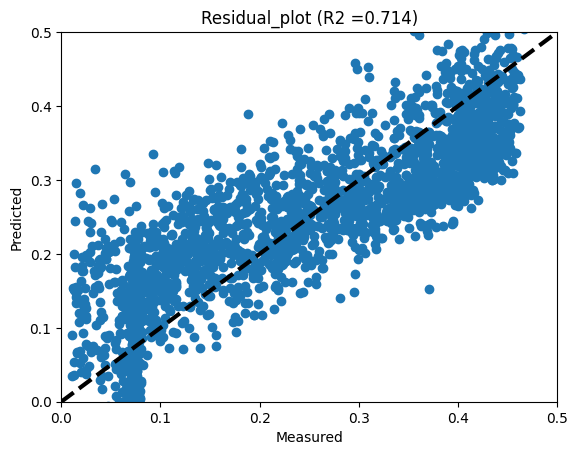

In [44]:
residual_plot(y_test, lin_reg_pred, score)